# Comparison of initialization methods for Gaussian mixtures

## Goal

Solution quality for the standard coordinate ascent algorithms like EM depend heavily on initialization quality.  Here, we'll see how bnpy can be used to run an experiment comparing two initialization methods, one smarter than the other.

In [1]:
import bnpy
import os

In [2]:
%pylab inline
from bnpy.viz.PlotUtil import ExportInfo
bnpy.viz.PlotUtil.ConfigPylabDefaults(pylab)

Populating the interactive namespace from numpy and matplotlib


## Toy dataset : `AsteriskK8`

We'll use a simple dataset of 2D points, drawn from 8 well-separated Gaussian clusters.

In [3]:
import AsteriskK8
Data = AsteriskK8.get_data()

We can visualize this dataset as follows:

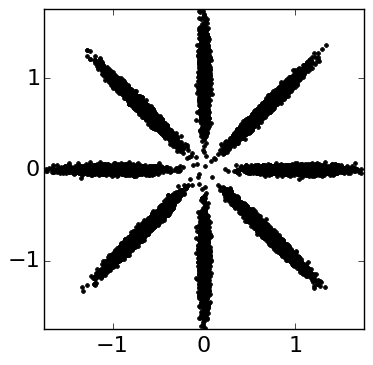

In [4]:
pylab.plot(Data.X[:,0], Data.X[:,1], 'k.');
pylab.axis('image'); 
pylab.xlim([-1.75, 1.75]); pylab.xticks([-1, 0, 1]);
pylab.ylim([-1.75, 1.75]); pylab.yticks([-1, 0, 1]);

## Initialization Methods

Our intended task is to train a Gaussian mixture model using expectation maximization (EM) with a maximum likelihood criterion. 

We'll consider two methods here to initialize the global parameters (means and covariances) of the Gaussian mixture model.

For more background on possible initializations, see the [Initialization documentation TODO](../Code/Initialization.md).

### Naive initialization: "select examples uniformly at random"

To initialize K clusters, we select K items uniformly at random from all N data items, and initialize the model as if each item was the only member of its corresponding component.

This procedure is called `randexamples` in **bnpy**. Note: this is the default initialization.

### Smart initialization: "select examples at random, biased by Euclidean distance"

One problem with the naive method is that it doesn't account for distances between selected points.  When using Gaussian observation models, it can be beneficial for initialized clusters to be spread out so a diverse set of points are likely to be represented. 

Concretely, we could modify the above procedure to choose K items in a distance-biased way, instead of uniformly at random.  We pick the first item at random from the data, and then for each successive component select an item n with probability proportional to its distance from the nearest chosen item among the $k$ previously chosen items.

This procedure is called `randexamplesbydist` in **bnpy**.

## Running the experiment with **bnpy**

We'll do 25 separate runs for each of the two initialization methods.  Each run gets at most 50 laps through the data, and uses 10 clusters.  

The **initname** argument specifies which initialization method to use, while the **jobname** is a human-readable name for the experiment.

### 25 runs from naive initialization: `randexamples`

In [5]:
# ExpectedRunTime=130sec
bnpy.run('AsteriskK8', 'FiniteMixtureModel', 'Gauss', 'EM', 
          K=8, initname='randexamples', jobname='compareinit-K=8-randexamples',
          nLap=100, minLaps=50, nTask=25, printEvery=100);

Asterisk Toy Data. 8 true clusters.
  size: 25000 units (single observations)
  dimension: 2
Allocation Model:  Finite mixture with K=8. Dir prior param 1.00
Obs. Data  Model:  Gaussian with full covariance.
Obs. Data  Prior:  Gauss-Wishart on each mean/prec matrix pair: mu, Lam
  E[ mu[k] ]     = [ 0.  0.]
  E[ CovMat[k] ] = 
  [[ 1.  0.]
   [ 0.  1.]]
Learn Alg: EM
Trial  1/25 | alg. seed: 7451264 | data order seed: 8541952
savepath: /results/AsteriskK8/compareinit-K=8-randexamples/1
        1/100 after      0 sec. | K    8 | ev -1.049632959e+07 |  
        2/100 after      0 sec. | K    8 | ev -7.512763667e-01 | Ndiff  390.461 
       78/100 after      9 sec. | K    8 | ev -3.833696280e-01 | Ndiff    0.047 
... done. converged.
Trial  2/25 | alg. seed: 5565568 | data order seed: 7673856
savepath: /results/AsteriskK8/compareinit-K=8-randexamples/2
        1/100 after      0 sec. | K    8 | ev -1.306152559e+07 |  
        2/100 after      0 sec. | K    8 | ev -8.778910794e-01 | Ndiff 

### 25 runs from smart initialization: `randexamplesbydist`


In [6]:
# ExpectedRunTime=130sec
bnpy.run('AsteriskK8', 'FiniteMixtureModel', 'Gauss', 'EM', 
          K=8, initname='randexamplesbydist', jobname='compareinit-K=8-randexamplesbydist',
          nLap=100,  minLaps=50, nTask=25, printEvery=100);

Asterisk Toy Data. 8 true clusters.
  size: 25000 units (single observations)
  dimension: 2
Allocation Model:  Finite mixture with K=8. Dir prior param 1.00
Obs. Data  Model:  Gaussian with full covariance.
Obs. Data  Prior:  Gauss-Wishart on each mean/prec matrix pair: mu, Lam
  E[ mu[k] ]     = [ 0.  0.]
  E[ CovMat[k] ] = 
  [[ 1.  0.]
   [ 0.  1.]]
Learn Alg: EM
Trial  1/25 | alg. seed: 7451264 | data order seed: 8541952
savepath: /results/AsteriskK8/compareinit-K=8-randexamplesbydist/1
        1/100 after      0 sec. | K    8 | ev -3.600496754e+06 |  
        2/100 after      0 sec. | K    8 | ev -4.445192734e-01 | Ndiff  575.970 
       50/100 after      6 sec. | K    8 | ev  1.084158115e-01 | Ndiff    0.000 
... done. converged.
Trial  2/25 | alg. seed: 5565568 | data order seed: 7673856
savepath: /results/AsteriskK8/compareinit-K=8-randexamplesbydist/2
        1/100 after      0 sec. | K    8 | ev -6.853334508e+06 |  
        2/100 after      0 sec. | K    8 | ev -6.669116077e

## Performance comparison: training objective as more data is seen

Using **bnpy**'s built-in visualization tools, we can easily make a plot comparing the two methods' performance at recovering the ideal set of 8 clusters.

This plot shows that across many runs, the `randexamplesbydist` procedure often reaches better objective function values than the simpler, more naive baseline. Of course, poor luck in the random initialization can still cause both methods to reach very poor objective values, which correspond to clusterings that group several real clusters together. However, this happens much less frequently with a good initialization.

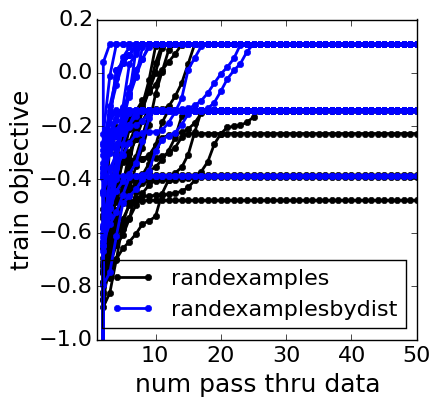

In [8]:
bnpy.viz.PlotELBO.plotJobsThatMatchKeywords('AsteriskK8/compareinit-K=8-*')
pylab.ylim([-1, 0.2]);
pylab.xlim([1, 50]);
pylab.legend(loc='lower right');
pylab.xlabel('num pass thru data');
pylab.ylabel('train objective');

## Discovered clusters: naive initialization

Here we show the discovered clusters for each of the 25 runs. The plot shows the runs in ranked order, from highest to lowest final objective function value. 

Clearly, the best runs with this method do find all 8 true clusters. In fact, 6 of the 25 runs do. But, this means that **19 of the 25 runs did not find the ideal clustering**.

SKIPPED 1 comps with size below 0.00


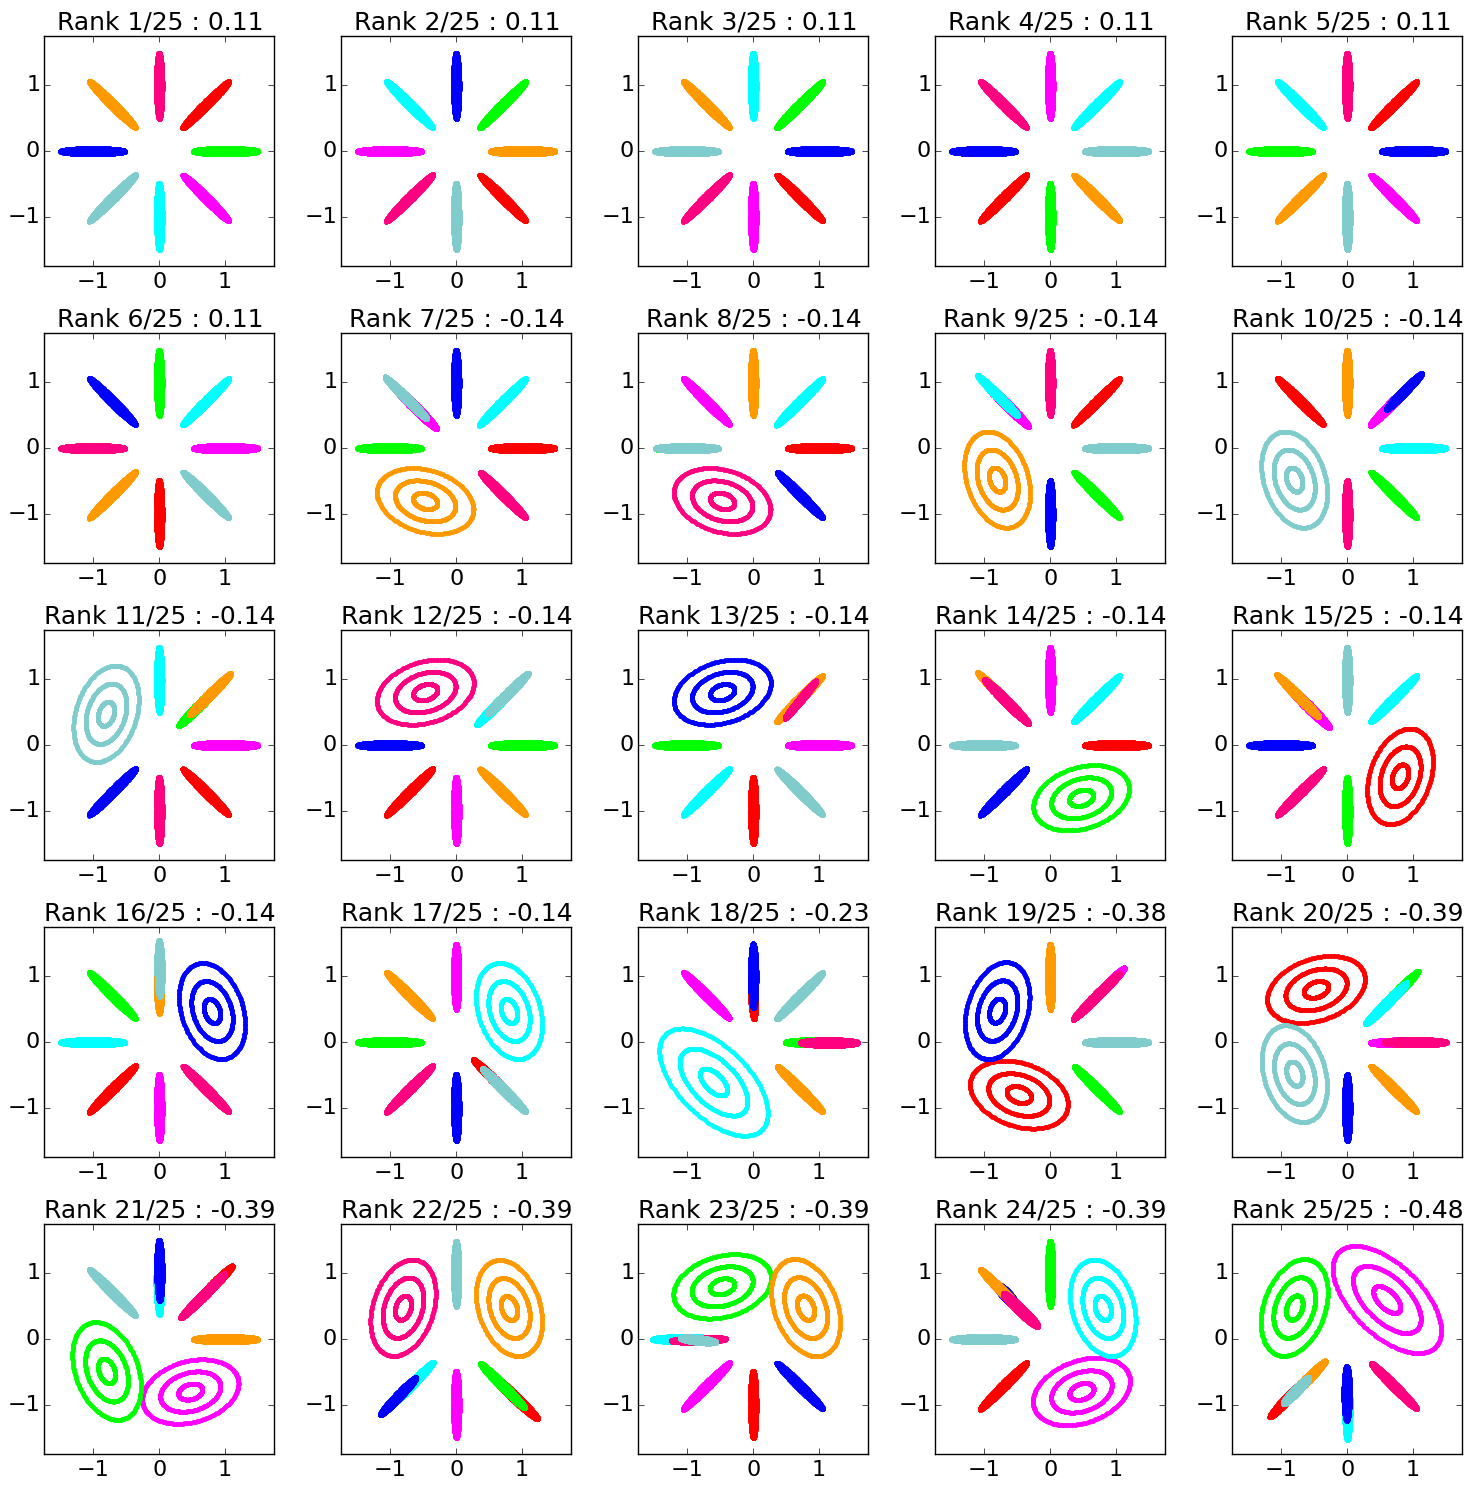

In [9]:
figH, axH = pylab.subplots(nrows=5, ncols=5, figsize=(15,15))
for plotID, rank in enumerate(range(1,26)):
    pylab.subplot(5,5, plotID+1)
    taskidstr = '.rank%d' % (rank)
    bnpy.viz.PlotComps.plotCompsForJob('AsteriskK8/compareinit-K=8-randexamples/', taskids=[taskidstr], figH=figH);
    ELBOpath = os.path.expandvars('$BNPYOUTDIR/AsteriskK8/compareinit-K=8-randexamples/%s/evidence.txt' % (taskidstr))
    finalELBOval = np.loadtxt(ELBOpath)[-1]
    pylab.axis('image'); pylab.xlim([-1.75, 1.75]); pylab.xticks([-1, 0, 1]); pylab.ylim([-1.75, 1.75]); pylab.yticks([-1, 0, 1]);
    pylab.title('Rank %d/25 : %.2f' % (rank, finalELBOval))
pylab.tight_layout()

# Ignore this block. Only needed for auto-generation of documentation.
if ExportInfo['doExport']:
    W_in, H_in = pylab.gcf().get_size_inches()
    figpath100 = '../docs/source/_static/GaussianToyData_FiniteMixtureModel_EM_CompareInitialization_%dx%d.png' % (100, 100)
    pylab.savefig(figpath100, bbox_inches=0, pad_inches=0, dpi=ExportInfo['dpi']/W_in);

## Discovered clusters: smart initialization

Here, we show the same plots for the smarter, initialize-by-distance runs.

Many more of the runs have discovered the ideal set of 8 clusters. However, still only 14 of the 25 runs find all 8 clusters. Clearly, smarter initialization helps, but we still need to take the best of many runs to get ideal performance.

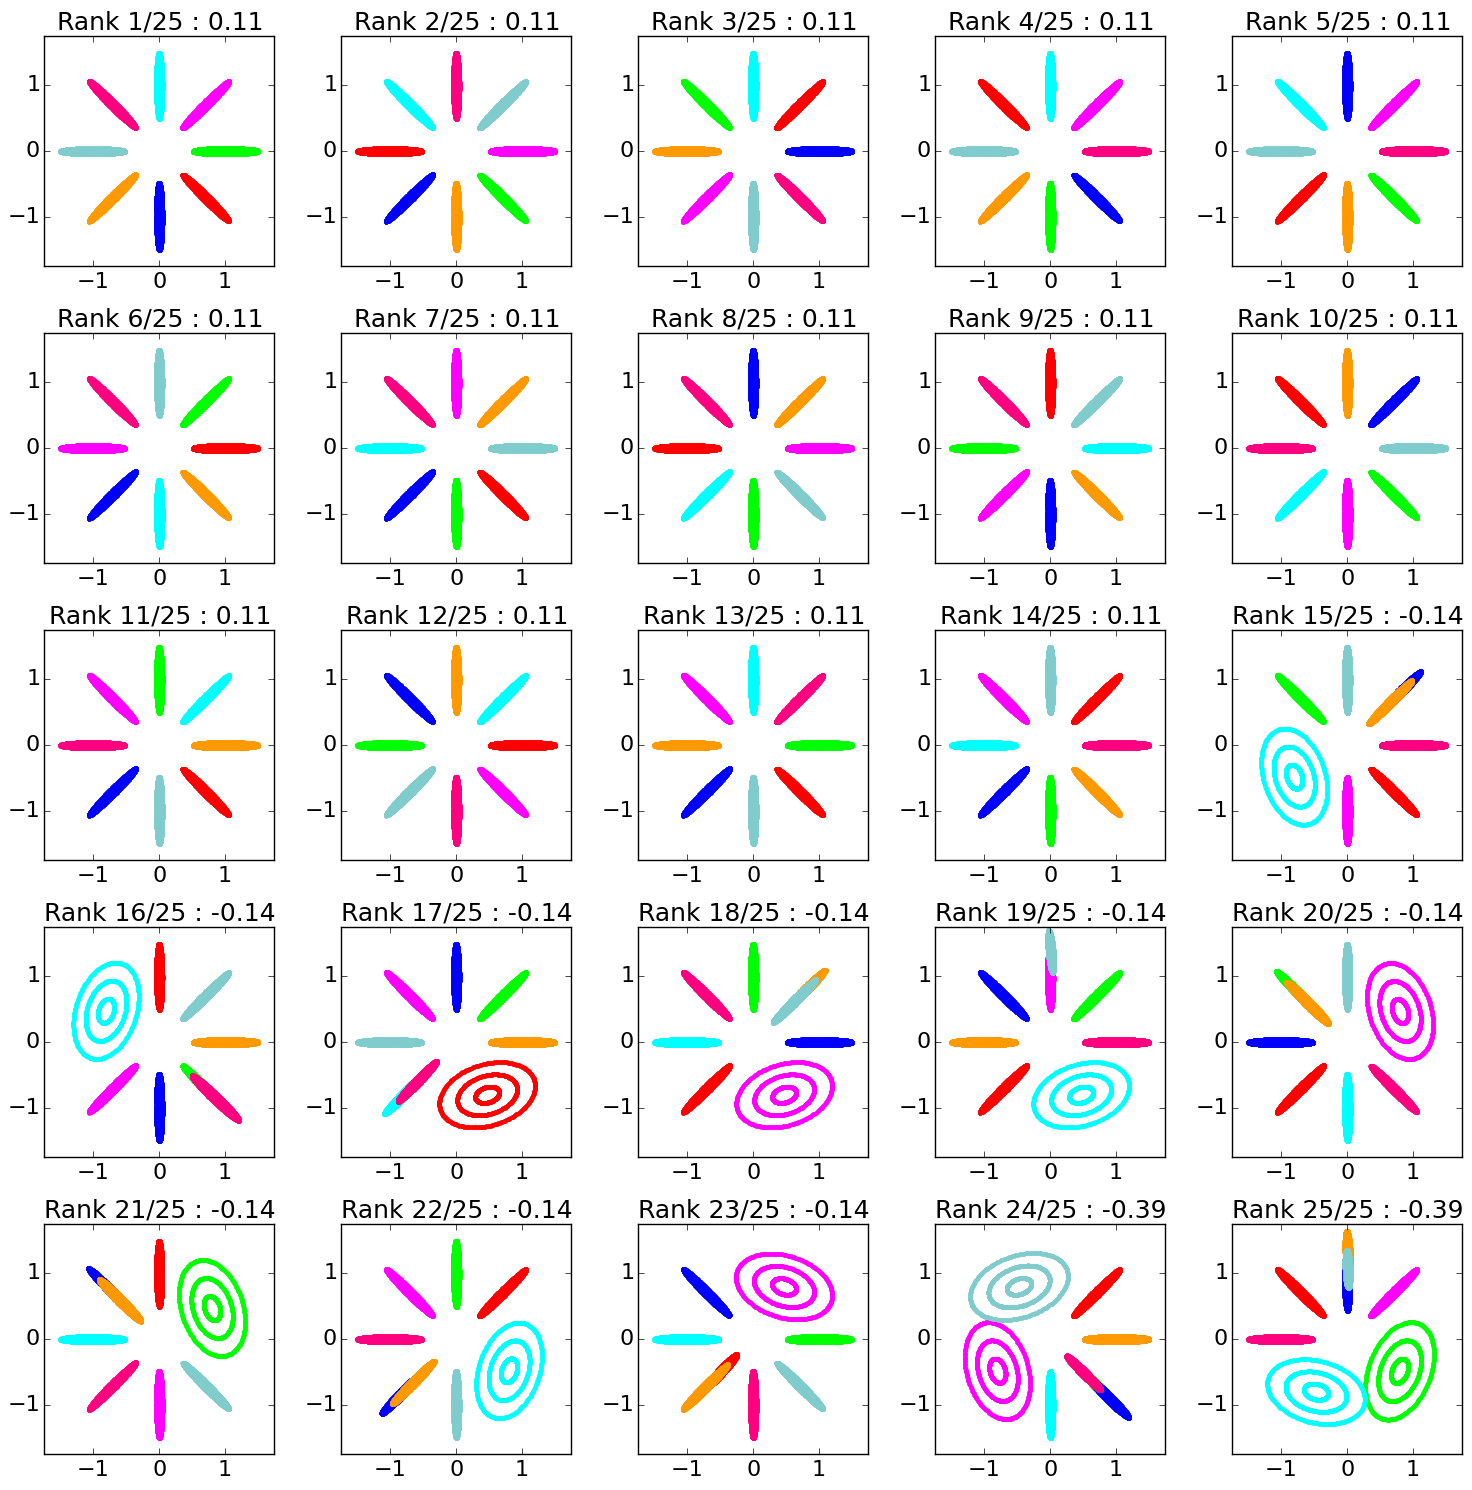

In [10]:
figH, axH = pylab.subplots(nrows=5, ncols=5, figsize=(15,15))
for plotID, rank in enumerate(range(1,26)):
    pylab.subplot(5,5, plotID+1)
    taskidstr = '.rank%d' % (rank)
    bnpy.viz.PlotComps.plotCompsForJob('AsteriskK8/compareinit-K=8-randexamplesbydist/', taskids=[taskidstr], figH=figH);
    ELBOpath = os.path.expandvars('$BNPYOUTDIR/AsteriskK8/compareinit-K=8-randexamplesbydist/%s/evidence.txt' % (taskidstr))
    finalELBOval = np.loadtxt(ELBOpath)[-1]
    pylab.axis('image'); pylab.xlim([-1.75, 1.75]); pylab.xticks([-1, 0, 1]); pylab.ylim([-1.75, 1.75]); pylab.yticks([-1, 0, 1]);
    pylab.title('Rank %d/25 : %.2f' % (rank, finalELBOval))
pylab.tight_layout()